# Import libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pickle

from ta.momentum import rsi, stoch, stoch_signal
from ta.volatility import average_true_range
from ta.volume import on_balance_volume

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import MaxPooling1D, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasRegressor

2024-11-09 09:48:25.231203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Get data from Yahoo Finance


In [2]:
def get_stock_data(ticker, start_date, end_date):

    df = yf.download(ticker, start=start_date, end=end_date)

    # Basic Price and Volume Data
    df['Open'] = df['Open']
    df['High'] = df['High']
    df['Low'] = df['Low']
    df['Close'] = df['Close']
    df['Adj Close'] = df['Adj Close']
    df['Volume'] = df['Volume']

    # Daily and Moving Average Indicators
    df['DailyReturn'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Volatility and Trend Indicators
    df['Volatility_bbh'] = df['Close'].rolling(window=20).mean() + 2 * df['Close'].rolling(window=20).std()
    df['Volatility_bbl'] = df['Close'].rolling(window=20).mean() - 2 * df['Close'].rolling(window=20).std()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

    # Technical Indicators
    df['RSI'] = rsi(df['Close'], window=14)
    df['ATR'] = average_true_range(df['High'], df['Low'], df['Close'], window=14)
    df['OBV'] = on_balance_volume(df['Close'], df['Volume'])

    df.reset_index(inplace=True)

    # Valuation ratios
    if ticker in ['AAPL', 'AMZN', 'GOOGL', 'MSFT']:
        stock = yf.Ticker(ticker)
        df['PE_TTM'] = stock.info.get('trailingPE')
        df['EPS_TTM'] = stock.info.get('trailingEps')
        df['PB'] = stock.info.get('priceToBook')
        df['PS_TTM'] = stock.info.get('priceToSalesTrailing12Months')
        df['Dividend_Yield'] = stock.info.get('dividendYield')

    return df

# Global Variables

In [3]:
start_date = '2019-01-01'
end_date = '2024-08-30'

# Data:
### Nasdaq Composite Index (IXIC), Standard & Poor's 500 Index (SP500), Dow Jones Industrial Average (DJI)

In [4]:
'''
df_nasdaq = get_stock_data('^IXIC', start_date, end_date)
df_sp500 = get_stock_data('^GSPC', start_date, end_date)
df_dji = get_stock_data('^DJI', start_date, end_date)

stocks = {'df_nasdaq': df_nasdaq, 'df_sp500': df_sp500, 'df_dji': df_dji}

for name, df in stocks.items():
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    filename = f"{name}.csv"
    df.to_csv(filename, index=False)
    print(f'Shape of {name}: {df.shape}')
'''

'\ndf_nasdaq = get_stock_data(\'^IXIC\', start_date, end_date)\ndf_sp500 = get_stock_data(\'^GSPC\', start_date, end_date)\ndf_dji = get_stock_data(\'^DJI\', start_date, end_date)\n\nstocks = {\'df_nasdaq\': df_nasdaq, \'df_sp500\': df_sp500, \'df_dji\': df_dji}\n\nfor name, df in stocks.items():\n    df.dropna(inplace=True)\n    df.reset_index(drop=True, inplace=True)\n    filename = f"{name}.csv"\n    df.to_csv(filename, index=False)\n    print(f\'Shape of {name}: {df.shape}\')\n'

In [5]:
# Run it if cannot use yfinance
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

stocks = {'df_nasdaq': df_nasdaq, 'df_sp500': df_sp500, 'df_dji': df_dji}

for name, df in stocks.items():
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    filename = f"{name}.csv"
    df.to_csv(filename, index=False)
    print(f'Shape of {name}: {df.shape}')

Shape of df_nasdaq: (1372, 19)
Shape of df_sp500: (1372, 19)
Shape of df_dji: (1372, 19)


In [6]:
df_sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DailyReturn,MA_10,MA_20,MA_50,EMA_100,EMA_200,Volatility_bbh,Volatility_bbl,MACD,RSI,ATR,OBV
0,2019-03-14,2810.379883,2815.000000,2803.459961,2808.479980,2808.479980,3505670000,-0.000868,2784.381982,2783.201978,2698.828594,2643.936130,2588.993734,2821.467669,2744.936286,25.116645,64.861327,25.243453,46216520000
1,2019-03-15,2810.790039,2830.729980,2810.790039,2822.479980,2822.479980,5969780000,0.004985,2786.260986,2787.039478,2705.077593,2647.471651,2591.316980,2824.873834,2749.205121,26.266630,67.511700,25.029635,52186300000
2,2019-03-18,2822.610107,2835.409912,2821.989990,2832.939941,2832.939941,3620770000,0.003706,2790.273975,2789.906470,2712.778594,2651.144291,2593.721189,2832.483788,2747.329151,27.702693,69.370563,24.200370,55807070000
3,2019-03-19,2840.760010,2852.419922,2823.270020,2832.570068,2832.570068,3650740000,-0.000131,2794.565991,2792.546973,2718.791196,2654.736880,2596.097795,2838.861049,2746.232896,28.482607,69.219743,24.553908,52156330000
4,2019-03-20,2831.340088,2843.540039,2812.429932,2824.229980,2824.229980,3779160000,-0.002944,2799.843994,2794.523474,2724.281997,2658.093179,2598.367767,2842.761538,2746.285411,28.103757,65.748608,25.022208,48377170000


In [8]:
df_sp500.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'DailyReturn', 'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200',
       'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR', 'OBV'],
      dtype='object')

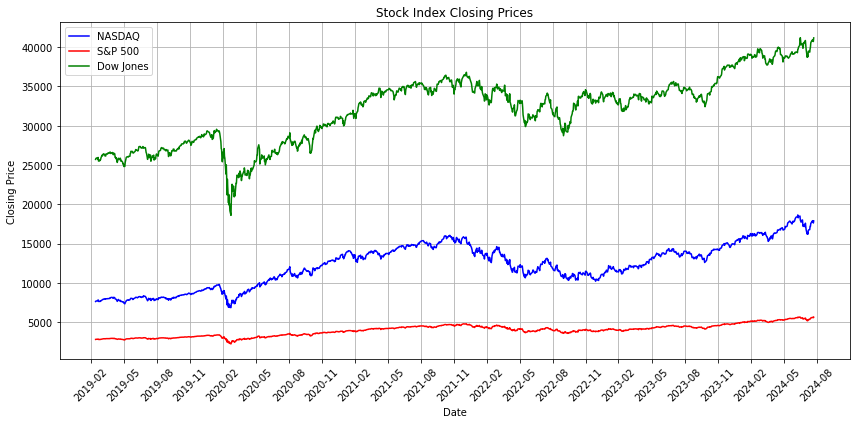

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(pd.to_datetime(df_nasdaq['Date']), df_nasdaq['Close'], label='NASDAQ', color='blue')
plt.plot(pd.to_datetime(df_sp500['Date']), df_sp500['Close'], label='S&P 500', color='red')
plt.plot(pd.to_datetime(df_dji['Date']), df_dji['Close'], label='Dow Jones', color='green')

plt.title('Stock Index Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [15]:
feature = ['Open', 'High', 'Low', 'Volume', 'DailyReturn', 'Adj Close',
           'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200', 
           'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR','OBV']
target = 'Close'

# Result of XGBoost feature selection, according to 7600_code_XGB_part
feature_xgb_nasdaq = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'Volatility_bbl']
feature_xgb_sp500 = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'MA_20']
feature_xgb_dji = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'OBV']


df_nasdaq_preprocessed = df_nasdaq[[target] + feature_xgb_nasdaq]
df_sp500_preprocessed = df_sp500[[target] + feature_xgb_sp500]
df_dji_preprocessed = df_dji[[target] + feature_xgb_dji]

In [16]:
def split_data(stock):
    stock = stock.to_numpy()
    test_set_size = int(np.round(0.2 * len(stock)))
    val_set_size = int(np.round(0.2 * len(stock)))
    train_set_size = len(stock) - test_set_size - val_set_size
    
    train = stock[:train_set_size, :]
    val = stock[train_set_size: train_set_size+val_set_size, :]
    test = stock[train_set_size+val_set_size:, :]

    return (train, val, test)

train, val, test = split_data(df_nasdaq_preprocessed)

In [17]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(f'Shape of scaled training Set: {scaled_train.shape}')
print(f'Shape of scaled training Set: {scaled_val.shape}')
print(f'Shape of scaled testing Set: {scaled_test.shape}')

Shape of scaled training Set: (824, 7)
Shape of scaled training Set: (274, 7)
Shape of scaled testing Set: (274, 7)


In [18]:
def createXY(dataset,lookback):
    dataX = []
    dataY = []
    for i in range(lookback, len(dataset)):
            dataX.append(dataset[i - lookback:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

lookback = 30

X_train, y_train = createXY(scaled_train,lookback)
X_val, y_val = createXY(scaled_val,lookback)
X_test, y_test = createXY(scaled_test,lookback)

print(f"shape of X_train:{np.shape(X_train)}, shape of y_train:{np.shape(y_train)}")
print(f"shape of X_train:{np.shape(X_val)}, shape of y_train:{np.shape(y_val)}")
print(f"shape of X_test:{np.shape(X_test)}, shape of y_test:{np.shape(y_test)}")

shape of X_train:(794, 30, 7), shape of y_train:(794,)
shape of X_train:(244, 30, 7), shape of y_train:(244,)
shape of X_test:(244, 30, 7), shape of y_test:(244,)


## Model 1 - LSTM

In [19]:
# GridSearchCV for Hyperparameters

'''
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=1, validation_data=(X_test,y_test), epochs=200, batch_size=16)

parameters = {'optimizer': ['Adam', 'Adadelta', 'SGD', 'RMSprop', 'Adagrad']}


grid = GridSearchCV(estimator = model, param_grid = parameters)
grid_result = grid.fit(X_train, y_train)
print(f"The best hyperparameters are: {grid_result.best_params_}")
'''

'\ndef create_model(optimizer=\'adam\'):\n    model = Sequential()\n    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))\n    model.add(Dropout(0.2))\n    model.add(LSTM(50))\n    model.add(Dropout(0.2))\n    model.add(Dense(1))\n    \n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    return model\n\nmodel = KerasRegressor(build_fn=create_model, verbose=1, validation_data=(X_test,y_test), epochs=200, batch_size=16)\n\nparameters = {\'optimizer\': [\'Adam\', \'Adadelta\', \'SGD\', \'RMSprop\', \'Adagrad\']}\n\n\ngrid = GridSearchCV(estimator = model, param_grid = parameters)\ngrid_result = grid.fit(X_train, y_train)\nprint(f"The best hyperparameters are: {grid_result.best_params_}")\n'

In [20]:
# The best optimizer is Adam (in 200 epochs)

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

# Define a custom callback to save the model every 50 epochs
def save_every_n_epochs(epoch, logs):
    if (epoch + 1) % 50 == 0:  # Save at 50, 100, 150, ..., 500 epochs
        filepath = f'lstm/nasdaq_lstm_epoch_{epoch + 1:03d}.h5'
        model.save(filepath)
        print(f'\nModel saved at {filepath}')

# Convert the function to a Keras callback
save_callback = LambdaCallback(on_epoch_end=save_every_n_epochs)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=500, batch_size=16, callbacks=[save_callback])
with open('lstm/nasdaq_lstm_training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

2024-11-09 09:51:36.477595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 09:51:36.484103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 09:51:36.484404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 09:51:36.485572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,851
Trainable params: 31,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2024-11-09 09:51:41.175014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


 1/50 [..............................] - ETA: 3:24 - loss: 0.3165 - mse: 0.3165 - mae: 0.4687

2024-11-09 09:51:42.073159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


50/50 [==============================] - 5s 18ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1072 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0625
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0590 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0422
Epoch 3/500
50/50 [==============================] - 0s 6ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0542 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0596
Epoch 4/500
50/50 [==============================] - 0s 6ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0497 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0602
Epoch 5/500
50/50 [==============================] - 0s 6ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0552 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0839
Epoch 6/500
50/50 [==============================] - 0s 6ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0508 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0369
Epoch 7/500
50/50 [==============

In [53]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

450

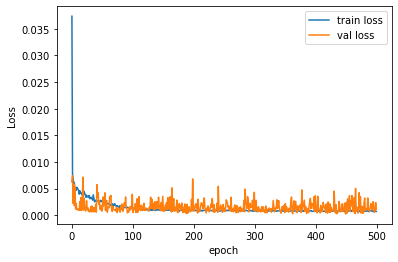

In [54]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

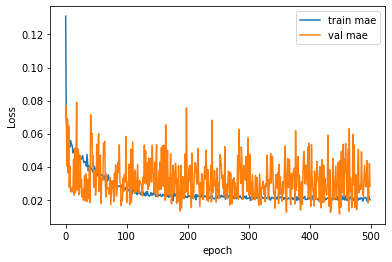

In [55]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 1 - LSTM - Plot

In [19]:
# The minimized val-loss epoch is 450, so that load weights of epoch_400 to predict.
model = load_model('lstm/nasdaq_lstm_epoch_350.h5')

y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('lstm/nasdaq_lstm_predictions.csv', index=False)

2024-08-30 00:42:09.680786: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


8/8 [==============================] - 2s 3ms/step


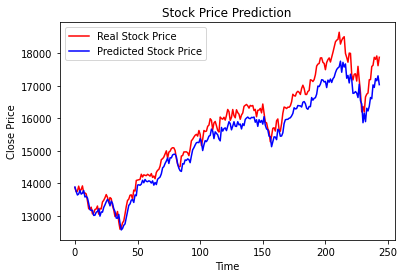

In [20]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Model 1 - LSTM - Error Metrics

In [ ]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 178575.8635402234
Mean Absolute Error (MAE): 351.4707471503586
R-squared (R²): 0.9245867877027003


## Model 2 - Bi-LSTM Model

In [59]:
# https://par.nsf.gov/servlets/purl/10186554

In [60]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

# Define a custom callback to save the model every 50 epochs
def save_every_n_epochs(epoch, logs):
    if (epoch + 1) % 50 == 0:  # Save at 50, 100, 150, ..., 500 epochs
        filepath = f'bi-lstm/dji_bi-lstm_epoch_{epoch + 1:03d}.h5'
        model.save(filepath)
        print(f'\nModel saved at {filepath}')

# Convert the function to a Keras callback
save_callback = LambdaCallback(on_epoch_end=save_every_n_epochs)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=500, batch_size=16, callbacks=[save_callback])
with open('bi-lstm/dji_bi-lstm_training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 30, 100)          23200     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 30, 100)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 83,701
Trainable params: 83,701
Non-trai

In [61]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

65

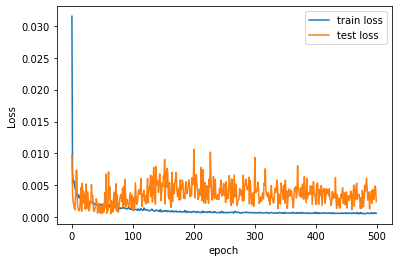

In [62]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

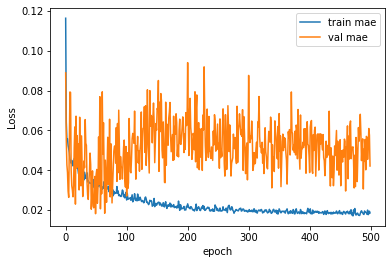

In [63]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 2 - Bi-LSTM - Plot

In [64]:
# The minimized val-loss epoch is 34, so that load weights of epoch_050 to predict.
model = load_model('bi-lstm/dji_bi-lstm_epoch_050.h5')

y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'bi-lstm': y_pred_inversed})
results_df.to_csv('bi-lstm/dji_bi-lstm_predictions.csv', index=False)

8/8 [==============================] - 1s 4ms/step


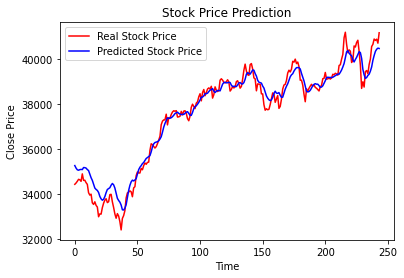

In [65]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Model 2 - Bi-LSTM - Error Metrics

In [66]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 185081.1234830014
Mean Absolute Error (MAE): 330.3584784836066
R-squared (R²): 0.9640105878876206


## Model 3 - CNN-LSTM Model

In [67]:
# https://onlinelibrary.wiley.com/doi/epdf/10.1155/2021/9903518
# https://www.kaggle.com/code/dkdevmallya/deep-learning-cnn-lstm-time-series-forecasting

In [68]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
# Don't need flatten

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

# Define a custom callback to save the model every 50 epochs
def save_every_n_epochs(epoch, logs):
    if (epoch + 1) % 50 == 0:  # Save at 50, 100, 150, ..., 500 epochs
        filepath = f'cnn-lstm/dji_cnn-lstm_epoch_{epoch + 1:03d}.h5'
        model.save(filepath)
        print(f'\nModel saved at {filepath}')

# Convert the function to a Keras callback
save_callback = LambdaCallback(on_epoch_end=save_every_n_epochs)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=500, batch_size=16, callbacks=[save_callback])
with open('cnn-lstm/dji_cnn-lstm_training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 32)            704       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 6, 50)             23000     
                                                                 
 dropout_12 (Dropout)        (None, 6, 50)            

In [69]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

9

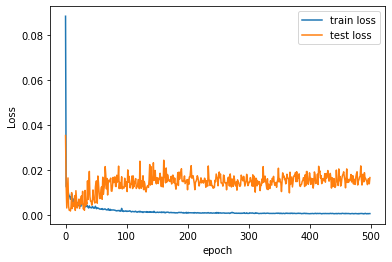

In [70]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

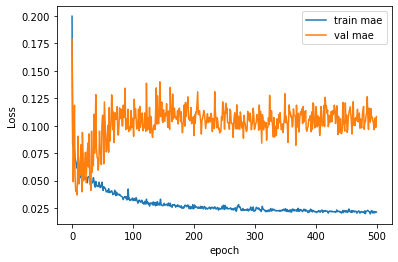

In [71]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 3 - CNN-LSTM - Plot

In [72]:
# The minimized val-loss epoch is 4, so that load weights of epoch_100 to predict.
model = load_model('cnn-lstm/dji_cnn-lstm_epoch_050.h5')

y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'cnn-lstm': y_pred_inversed})
results_df.to_csv('cnn-lstm/dji_cnn-lstm_predictions.csv', index=False)

8/8 [==============================] - 0s 3ms/step


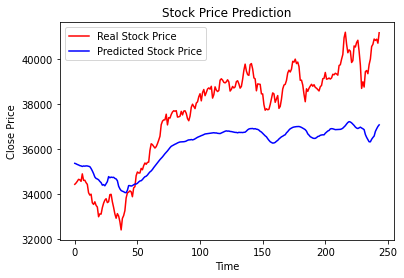

In [75]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Model 3 - CNN-LSTM - Error Metrics

In [76]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 4205832.35204847
Mean Absolute Error (MAE): 1839.6916143698777
R-squared (R²): 0.18216709005793152


# Other Indexes/Stocks

In [77]:
'''
df_hsi = get_stock_data('^HSI', start_date, end_date)
df_cac40 = get_stock_data('^FCHI', start_date, end_date)
df_nasdaq = get_stock_data('^IXIC', start_date, end_date)
df_sp500 = get_stock_data('^GSPC', start_date, end_date)
df_dji = get_stock_data('^DJI', start_date, end_date)

df_aapl = get_stock_data('AAPL', start_date, end_date)
df_amzn = get_stock_data('AMZN', start_date, end_date)
df_googl = get_stock_data('GOOGL', start_date, end_date)
df_msft = get_stock_data('MSFT', start_date, end_date)
'''

# display(df_hsi.head(3))
# display(df_cac40.head(3))
# display(df_nasdaq.head(3))
# display(df_sp500.head(3))
# display(df_dji.head(3))

# display(df_aapl.head(3))
# display(df_amzn.head(3))
# display(df_googl.head(3))
# display(df_msft.head(3))

"\ndf_hsi = get_stock_data('^HSI', start_date, end_date)\ndf_cac40 = get_stock_data('^FCHI', start_date, end_date)\ndf_nasdaq = get_stock_data('^IXIC', start_date, end_date)\ndf_sp500 = get_stock_data('^GSPC', start_date, end_date)\ndf_dji = get_stock_data('^DJI', start_date, end_date)\n\ndf_aapl = get_stock_data('AAPL', start_date, end_date)\ndf_amzn = get_stock_data('AMZN', start_date, end_date)\ndf_googl = get_stock_data('GOOGL', start_date, end_date)\ndf_msft = get_stock_data('MSFT', start_date, end_date)\n"

# References

In [39]:
# https://github.com/yllvar/Stock-Prediction-LTSM